In [1]:
import json
import os
import ml_collections
import torch
import matplotlib.pyplot as plt
import tqdm

from lightning.pytorch import seed_everything
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2
from seisLM.data_pipeline import collator
from seisLM.model.foundation import pretrained_models

from seisLM.utils.project_path import gitdir
from seisLM.data_pipeline.pretrain_dataloaders import prepare_pretrain_dataloaders
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders
)

DEFAULT_NUM_WORKERS = 4

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ckpt_dict = {
  'rope_peak': "/results/models/pretrained_seisLM/pretrain_config_layernorm_peak_mean_rope_small_batch_6_datasets_42__2024-08-04-03h-27m-23s/checkpoints/epoch=39-step=1051520.ckpt",
  'conv_peak':  "/results/models/pretrained_seisLM/pretrain_config_layernorm_peak_small_batch_6_datasets_42__2024-08-03-21h-32m-39s/checkpoints/epoch=37-step=998944.ckpt",
  'conv_std': "/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_4_datasets_less_regularized_42__2024-08-07-16h-54m-15s/checkpoints/epoch=16-step=297449.ckpt"
}


loaders = {}
models = {}

for ckpt_label, pretrained_ckpt_path in  ckpt_dict.items():

  pretrained_model_lit = pretrained_models.LitMultiDimWav2Vec2.load_from_checkpoint(
      gitdir() + pretrained_ckpt_path
  )

  config = pretrained_model_lit.config
  config.data_config.local_batch_size = 8
  model = pretrained_model_lit
  device = model.device

  model.eval()
  models[ckpt_label] = model

  data_collator = \
    collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
        config=config.model_config,
        mask_time_prob=config.training_config.mask_time_prob,
        mask_time_length=config.training_config.mask_time_length,
    )


  _, pretrain_dev_loaders = prepare_pretrain_dataloaders(
    model=model,
    training_fraction=config.data_config.training_fraction,
    data_names=['ETHZ', 'Iquique'], #config.data_config.data_name,
    batch_size=config.data_config.local_batch_size,
    num_workers=config.data_config.num_workers,
    prefetch_factor=config.data_config.prefetch_factor,
    collator=data_collator,
    cache=config.data_config.cache_dataset,
  )
  loaders[ckpt_label] = pretrain_dev_loaders
  del model, pretrained_model_lit, data_collator, pretrain_dev_loaders, config


2024-08-09 17:14:04,133 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-08-09 17:14:04,396 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
Seed set to 42
Seed set to 42
2024-08-09 17:14:06,823 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-08-09 17:14:07,098 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
Seed set to 42
Seed set to 42
/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.3.

## visualize features

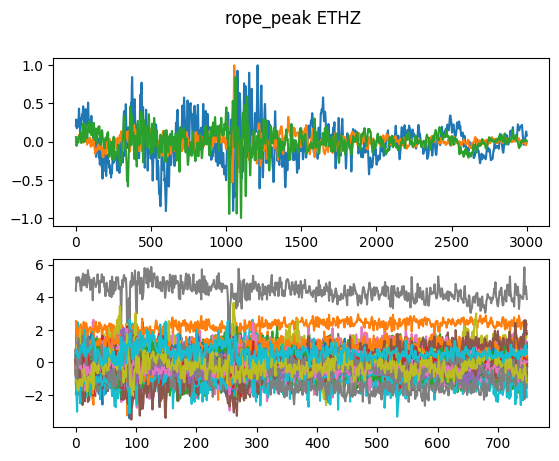

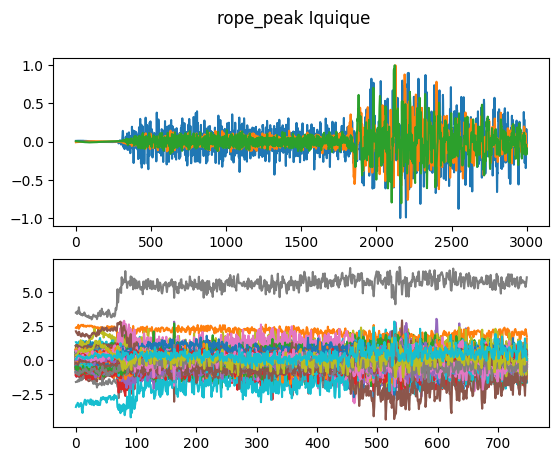

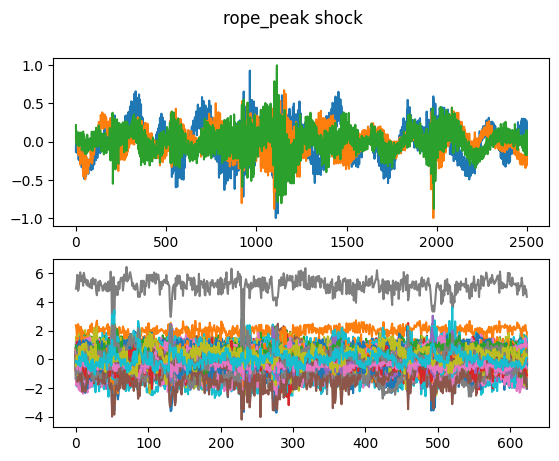

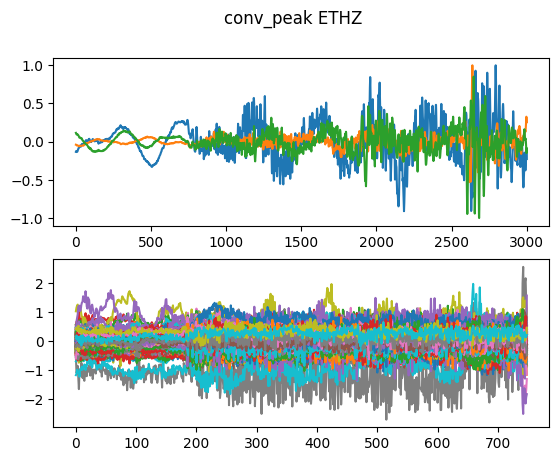

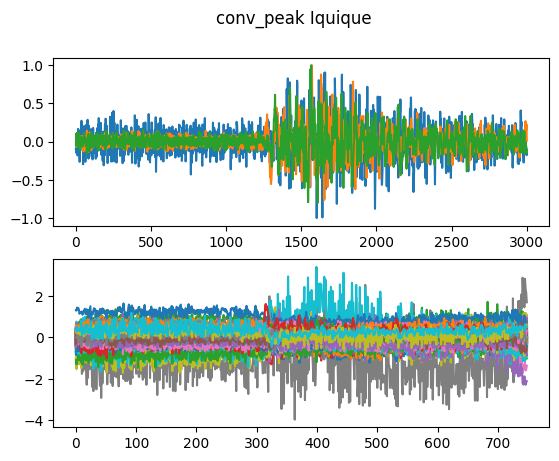

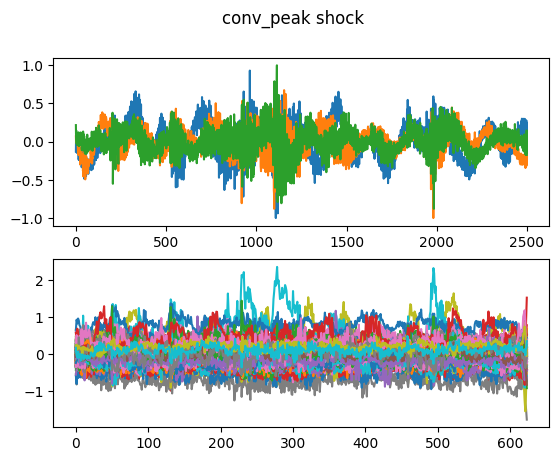

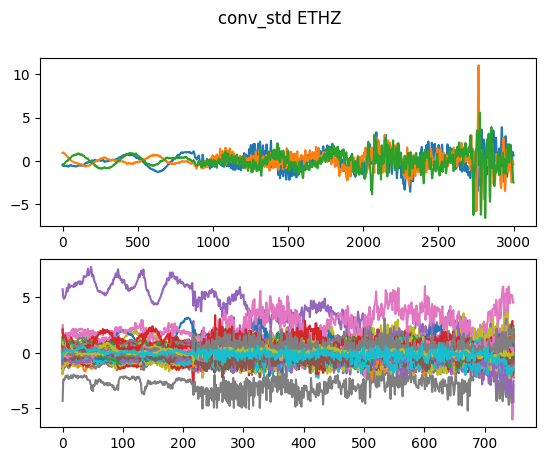

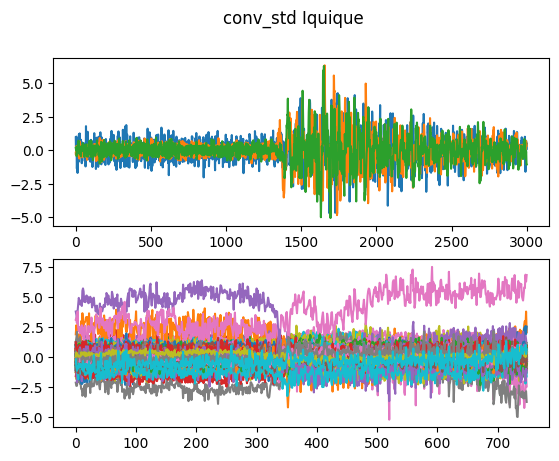

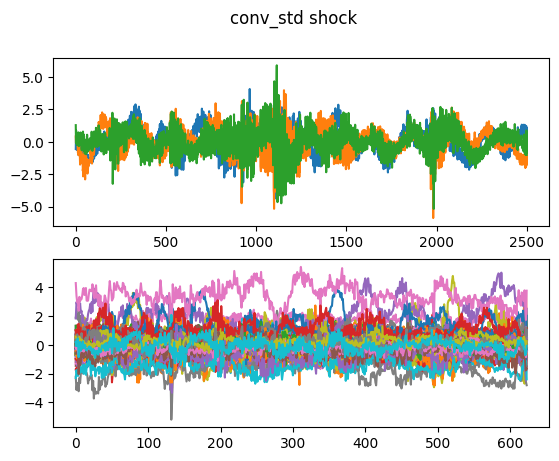

In [3]:
for ckpt_label, pretrained_ckpt_path in  ckpt_dict.items():
  model = models[ckpt_label]
  pretrain_dev_loaders = loaders[ckpt_label]

  for dataset_name, loader in loaders[ckpt_label].items():
    batch = next(iter(loader))

    fig, axes = plt.subplots(2, 1)

    axes[0].plot(batch['input_values'][0].T.detach().cpu());

    for k, v in batch.items():
      batch[k] = v.to(model.device)

    with torch.no_grad():
      out = model.model.wav2vec2(batch['input_values'])
      axes[1].plot(out.last_hidden_state[0].detach().cpu());

    plt.suptitle(f'{ckpt_label} {dataset_name}')

# show loss

In [4]:
def evaluate_self_supervised_loss(model, loader):
  all_losses = []
  for batch in tqdm.tqdm(loader):
    for k, v in batch.items():
      batch[k] = v.to(model.device)

    mask_time_indices = batch["mask_time_indices"]
    num_losses = mask_time_indices.sum()

    with torch.no_grad():
      out = model.model(**batch)
    all_losses.append(out.loss / num_losses)

  return sum(all_losses) / len(all_losses)

In [5]:



for ckpt_label, pretrained_ckpt_path in  ckpt_dict.items():

  model = models[ckpt_label]
  pretrain_dev_loaders = loaders[ckpt_label]

  for val_name, val_loader in pretrain_dev_loaders.items():
    pretrain_loss = evaluate_self_supervised_loss(model, val_loader)
    print(f'ckpt {ckpt_label} pretrain loss, {pretrain_loss}, {val_name}')

100%|██████████| 454/454 [00:25<00:00, 17.72it/s]


ckpt rope_peak pretrain loss, 3.759126663208008, ETHZ


100%|██████████| 168/168 [00:09<00:00, 17.46it/s]


ckpt rope_peak pretrain loss, 3.5629513263702393, Iquique


100%|██████████| 91/91 [00:04<00:00, 20.92it/s]


ckpt rope_peak pretrain loss, 3.9761035442352295, shock


100%|██████████| 454/454 [00:27<00:00, 16.69it/s]


ckpt conv_peak pretrain loss, 3.866323471069336, ETHZ


100%|██████████| 168/168 [00:10<00:00, 16.33it/s]


ckpt conv_peak pretrain loss, 3.7651658058166504, Iquique


100%|██████████| 91/91 [00:04<00:00, 19.36it/s]


ckpt conv_peak pretrain loss, 3.9574601650238037, shock


100%|██████████| 454/454 [00:27<00:00, 16.55it/s]


ckpt conv_std pretrain loss, 3.8321633338928223, ETHZ


100%|██████████| 168/168 [00:10<00:00, 16.35it/s]


ckpt conv_std pretrain loss, 3.762742280960083, Iquique


100%|██████████| 91/91 [00:04<00:00, 19.24it/s]

ckpt conv_std pretrain loss, 3.9307329654693604, shock
